# Notatnik do testowania modelu autoenkodera

1. Zainstalowanie wszystkich pakietów wymaganych do działania notatnika
```pip install -r requirements.txt```

2. Ustawienie ścieżek do obrazów (`noisy_image_path` i `clean_image_path` w komórce poniżej)

3. Uruchomienie wszystkich komórek w kolejności

4. Sprawdzenie wyników w oknie wyświetlanym po uruchomieniu ostatniej komórki

In [63]:
# sciezka do obrazu uszkodzonej elipsy
noisy_image_path = 'testData/noisy/slice_0012.png'
# sciezka do oryginalnego obrazu elipsy
clean_image_path = 'testData/clean/slice_0012.png'

In [64]:
model_path = 'best_model.pth'

In [65]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder layers
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        
        # Decoder layers
        self.dec1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        
        # Decoder with skip connections
        d1 = self.dec1(e3)
        d1 = torch.cat([d1, e2], dim=1)  # Skip connection
        d2 = self.dec2(d1)
        d2 = torch.cat([d2, e1], dim=1)  # Skip connection
        d3 = self.dec3(d2)
        return d3

def load_model(model_path):
    return torch.load(model_path)

def denoise_image(model, image_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=(0, 1))  # Add batch and channel dimensions
    img_tensor = torch.FloatTensor(img).to(device)
    
    with torch.no_grad():
        denoised = model(img_tensor)
    
    # Convert back to image
    denoised = denoised.cpu().numpy()[0, 0]
    denoised = (denoised * 255).astype(np.uint8)
    
    return denoised

def dice_coefficient(img1, img2):
    # Normalize images to binary (0 or 1)
    img1_binary = (img1 > 127).astype(np.float32)
    img2_binary = (img2 > 127).astype(np.float32)
    
    # Calculate intersection and union
    intersection = np.sum(img1_binary * img2_binary)
    union = np.sum(img1_binary) + np.sum(img2_binary)
    
    # Avoid division by zero
    if union == 0:
        return 1.0
        
    return (2.0 * intersection) / union

def compare_images(noisy_image, denoised_image, clean_image):
    # Calculate Dice coefficient between denoised and clean image
    dice_score = dice_coefficient(denoised_image, clean_image)
    print(f"Dice Coefficient: {dice_score:.4f}")

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 3, 1)
    plt.title('Noisy Image')
    plt.imshow(noisy_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Denoised Image')
    plt.imshow(denoised_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Clean Image')
    plt.imshow(clean_image, cmap='gray')
    plt.axis('off')
    plt.show()

def denoise_and_compare(model, noisy_image_path, clean_image_path):
    noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_GRAYSCALE)
    denoised_image = denoise_image(model, noisy_image_path)
    clean_image = cv2.imread(clean_image_path, cv2.IMREAD_GRAYSCALE)
    compare_images(noisy_image, denoised_image, clean_image)


# Wynik

Dice Coefficient: 0.9992


/tmp/ipykernel_66776/3910510738.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(model_path)


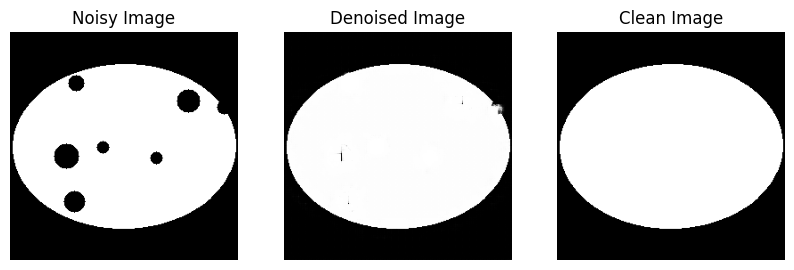

In [66]:
model = load_model(model_path)
denoise_and_compare(model, noisy_image_path, clean_image_path)
